In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

In [3]:
!pip install xgboost
!pip install lightgbm


In [4]:
! "C:\Users\LENOVO THINKPAD 13\AppData\Local\Programs\Python\Python313\python.exe" -m pip install --upgrade pip
! "C:\Users\LENOVO THINKPAD 13\AppData\Local\Programs\Python\Python313\python.exe" -m pip install xgboost lightgbm


In [5]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

print("Both imports succeeded!")


Both imports succeeded!


In [6]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


In [9]:
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, roc_curve, auc
)
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils import resample


import joblib
import warnings
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

In [11]:
df = pd.read_csv(r"C:\Users\LENOVO THINKPAD 13\Downloads\XGBM & LGBM (1)\Titanic_test.csv")
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [12]:
# 3) Quick EDA
# ---------------------------
print("\n--- INFO ---")
print(df.info())
print("\n--- Missing values ---")
print(df.isnull().sum().sort_values(ascending=False))
print("\n--- Descriptive stats (numeric) ---")
print(df.describe())


--- INFO ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB
None

--- Missing values ---
Cabin          327
Age             86
Fare             1
Name             0
Pclass           0
PassengerId      0
Sex              0
Parch            0
SibSp            0
Ticket           0
Embarked         0
dtype: int64

--- Descriptive stat

In [19]:
# Load the train dataset
df = pd.read_csv(r"C:\Users\LENOVO THINKPAD 13\Downloads\XGBM & LGBM (1)\Titanic_train.csv")

# Preview first rows
df.head(9)

# Normalize column names to lowercase (optional, makes code consistent)
df.columns = df.columns.str.lower()

# Now you can check
print(df.columns)
# You should see 'survived' among them

# Quick check of the target distribution
print(df['survived'].value_counts())


Index(['passengerid', 'survived', 'pclass', 'name', 'sex', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')
survived
0    549
1    342
Name: count, dtype: int64


In [20]:
df.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


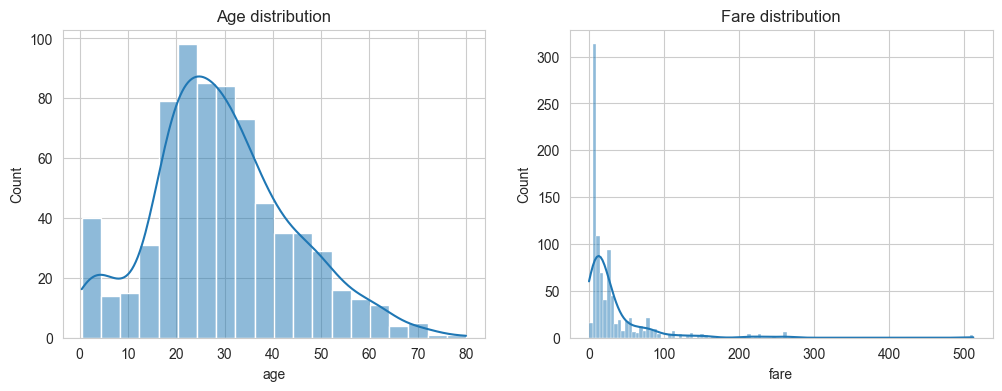

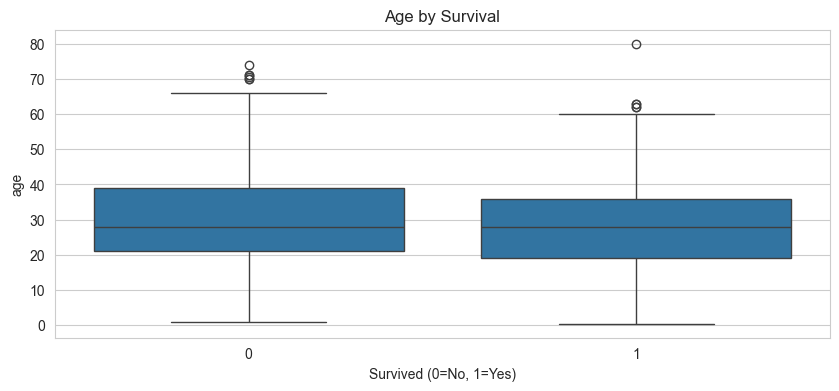

In [22]:
# Visualizations (histograms and boxplots)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(df['age'].dropna(), kde=True)
plt.title("Age distribution")

plt.subplot(1,2,2)
sns.histplot(df['fare'].dropna(), kde=True)
plt.title("Fare distribution")
plt.show()

plt.figure(figsize=(10,4))
sns.boxplot(x='survived', y='age', data=df)
plt.title("Age by Survival")
plt.xlabel("Survived (0=No, 1=Yes)")
plt.show()


In [26]:
features = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']
target = 'survived'

# Keep selected subset (drop rows with no target)
data = df[features + [target]].copy()

# We'll treat pclass as categorical (1,2,3)
categorical_cols = ['pclass', 'sex', 'embarked']
numerical_cols = ['age', 'sibsp', 'parch', 'fare']

# Define pipelines for numeric and categorical
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])


In [27]:
# 5) Train-test split
# ---------------------------
X = data[features]
y = data[target].astype(int)  # ensure ints

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# Optional: print class balance
print("\nClass balance (train):")
print(y_train.value_counts(normalize=True))


Train shape: (712, 7) Test shape: (179, 7)

Class balance (train):
survived
0    0.616573
1    0.383427
Name: proportion, dtype: float64


In [28]:
# 6) Pipelines for models
# ---------------------------
lgbm_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', LGBMClassifier(random_state=42, n_jobs=-1))
])

xgb_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1))
])


In [31]:
#7)Hyperparameter search (RandomizedSearchCV)
# ---------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

lgbm_param_dist = {
    'clf__n_estimators': [50, 100, 200, 400],
    'clf__num_leaves': [15, 31, 50, 80],
    'clf__learning_rate': [0.01, 0.03, 0.05, 0.1],
    'clf__max_depth': [-1, 3, 5, 8],
    'clf__subsample': [0.6, 0.8, 1.0],
    'clf__colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_param_dist = {
    'clf__n_estimators': [50, 100, 200, 400],
    'clf__max_depth': [3, 4, 6, 8],
    'clf__learning_rate': [0.01, 0.03, 0.05, 0.1],
    'clf__subsample': [0.6, 0.8, 1.0],
    'clf__colsample_bytree': [0.6, 0.8, 1.0],
    'clf__reg_alpha': [0, 0.1, 1],
    'clf__reg_lambda': [1, 2, 5]
}

# We optimize for F1 because dataset is moderately imbalanced and we want a balance of precision & recall.
lgbm_search = RandomizedSearchCV(
    estimator=lgbm_pipe,
    param_distributions=lgbm_param_dist,
    n_iter=30,
    scoring='f1',
    n_jobs=-1,
    cv=cv,
    verbose=1,
    random_state=42
)

xgb_search = RandomizedSearchCV(
    estimator=xgb_pipe,
    param_distributions=xgb_param_dist,
    n_iter=30,
    scoring='f1',
    n_jobs=-1,
    cv=cv,
    verbose=1,
    random_state=42
)

In [32]:
# 8) Fit searches (this may take a while)
# ---------------------------
print("Starting LGBM search...")
lgbm_search.fit(X_train, y_train)
print("Best LGBM params:", lgbm_search.best_params_)
print("Best LGBM CV score (F1):", lgbm_search.best_score_)

print("\nStarting XGB search...")
xgb_search.fit(X_train, y_train)
print("Best XGB params:", xgb_search.best_params_)
print("Best XGB CV score (F1):", xgb_search.best_score_)


Starting LGBM search...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 216
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best


--- LightGBM (best) ---
Accuracy: 0.7821229050279329
Precision: 0.7586206896551724
Recall: 0.6376811594202898
F1: 0.6929133858267716
ROC AUC: 0.8013175230566535

Classification report:
               precision    recall  f1-score   support

           0       0.79      0.87      0.83       110
           1       0.76      0.64      0.69        69

    accuracy                           0.78       179
   macro avg       0.78      0.76      0.76       179
weighted avg       0.78      0.78      0.78       179



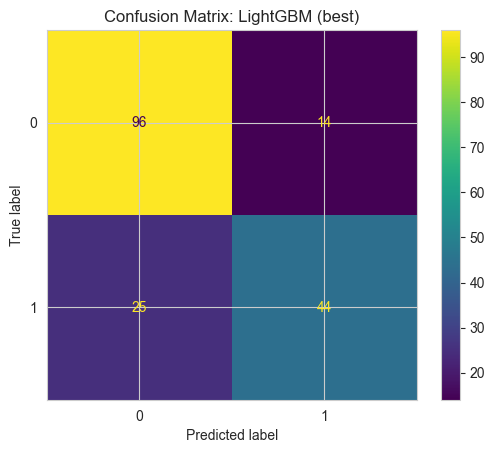


--- XGBoost (best) ---
Accuracy: 0.7988826815642458
Precision: 0.7796610169491526
Recall: 0.6666666666666666
F1: 0.71875
ROC AUC: 0.8321475625823451

Classification report:
               precision    recall  f1-score   support

           0       0.81      0.88      0.84       110
           1       0.78      0.67      0.72        69

    accuracy                           0.80       179
   macro avg       0.79      0.77      0.78       179
weighted avg       0.80      0.80      0.80       179



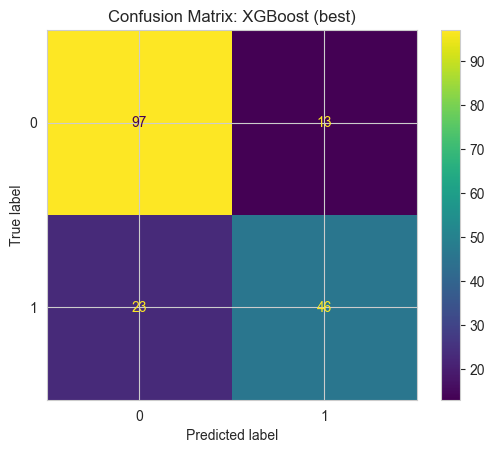


Summary of test metrics:


,accuracy,precision,recall,f1,roc_auc
LightGBM,0.782123,0.758621,0.637681,0.692913,0.801318
XGBoost,0.798883,0.779661,0.666667,0.718750,0.832148


In [33]:
# ---------------------------
# 9) Evaluate best models on test set
# ---------------------------
best_lgbm = lgbm_search.best_estimator_
best_xgb = xgb_search.best_estimator_

def evaluate_model(model, X_test, y_test, label="Model"):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

    print(f"\n--- {label} ---")
    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1:", f1)
    print("ROC AUC:", roc)
    print("\nClassification report:\n", classification_report(y_test, y_pred, zero_division=0))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
    disp.plot()
    plt.title(f"Confusion Matrix: {label}")
    plt.show()

    return dict(accuracy=acc, precision=prec, recall=rec, f1=f1, roc_auc=roc)

metrics_lgbm = evaluate_model(best_lgbm, X_test, y_test, label="LightGBM (best)")
metrics_xgb  = evaluate_model(best_xgb,  X_test, y_test, label="XGBoost (best)")

# Summarize metrics in a DataFrame
results_df = pd.DataFrame([metrics_lgbm, metrics_xgb], index=["LightGBM", "XGBoost"])
print("\nSummary of test metrics:")
display(results_df)

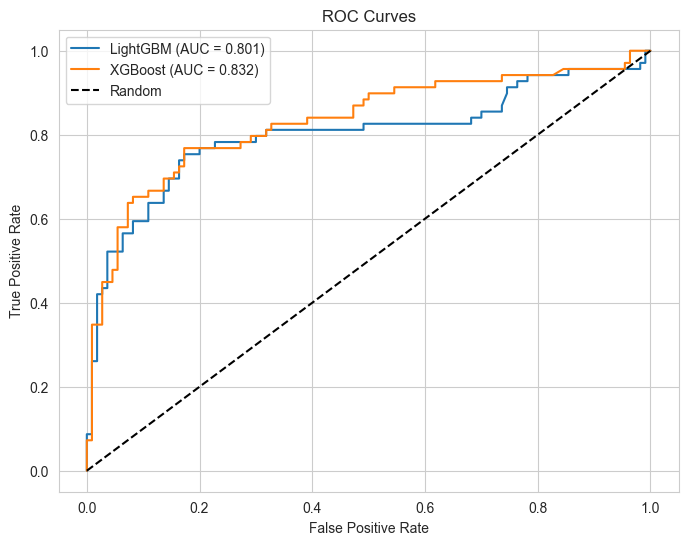

In [34]:
# 10) ROC curve comparison
# ---------------------------
plt.figure(figsize=(8,6))
for model, name in [(best_lgbm, 'LightGBM'), (best_xgb, 'XGBoost')]:
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")
plt.plot([0,1],[0,1],'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()


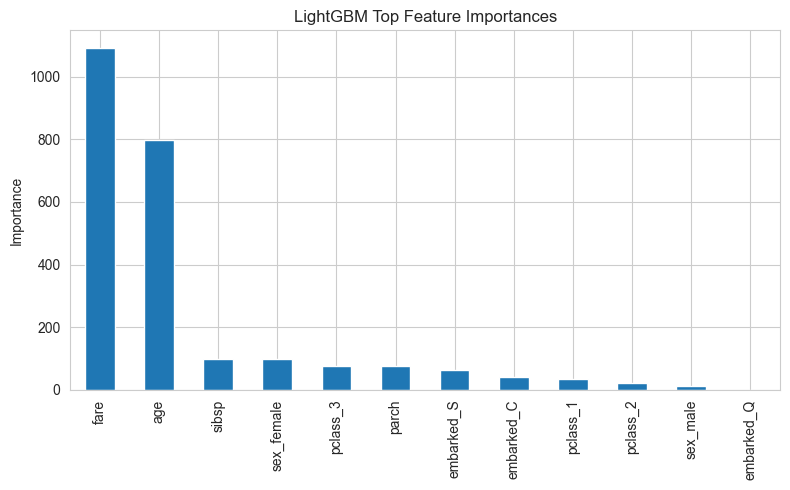

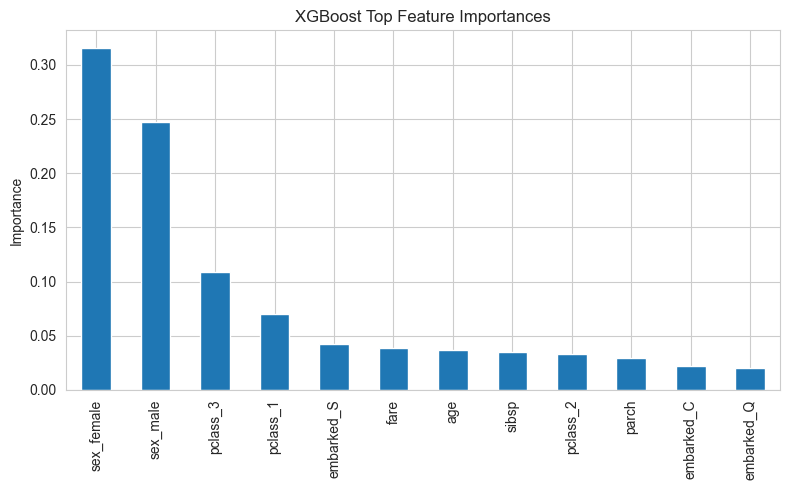

In [36]:
# ==============================
# Feature Importances (Safe)
# ==============================
def get_feature_names_from_pipeline(pipeline, numerical_cols, categorical_cols):
    """
    Extract feature names from a fitted pipeline with ColumnTransformer
    Handles numeric + one-hot encoded categorical features
    """
    preprocessor_fitted = pipeline.named_steps['preprocessor']  # must be fitted

    # Numeric feature names
    num_features = numerical_cols

    # Categorical feature names (one-hot)
    try:
        cat_transformer = preprocessor_fitted.named_transformers_['cat']
        ohe = cat_transformer.named_steps['onehot']
        cat_features = list(ohe.get_feature_names_out(categorical_cols))
    except Exception:
        # Fallback if old sklearn version or no onehot
        cat_features = categorical_cols

    return list(num_features) + list(cat_features)

# Get feature names from each pipeline
feature_names_lgbm = get_feature_names_from_pipeline(best_lgbm, numerical_cols, categorical_cols)
feature_names_xgb  = get_feature_names_from_pipeline(best_xgb, numerical_cols, categorical_cols)

# Plot function
def plot_feature_importances(model, feature_names, title="Feature Importances"):
    import matplotlib.pyplot as plt
    import pandas as pd

    try:
        importances = model.named_steps['clf'].feature_importances_
        fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)[:20]
        plt.figure(figsize=(8,5))
        fi.plot(kind='bar')
        plt.title(title)
        plt.ylabel("Importance")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not plot feature importances: {e}")

# LightGBM
plot_feature_importances(best_lgbm, feature_names_lgbm, "LightGBM Top Feature Importances")

# XGBoost
plot_feature_importances(best_xgb, feature_names_xgb, "XGBoost Top Feature Importances")


In [37]:
# 12) Save best models (optional)
# ---------------------------
joblib.dump(best_lgbm, "best_lgbm_titanic.joblib")
joblib.dump(best_xgb, "best_xgb_titanic.joblib")
print("Saved best models to disk: best_lgbm_titanic.joblib, best_xgb_titanic.joblib")


Saved best models to disk: best_lgbm_titanic.joblib, best_xgb_titanic.joblib



--- LightGBM ---
Accuracy: 0.7821229050279329
Precision: 0.7586206896551724
Recall: 0.6376811594202898
F1: 0.6929133858267716
ROC AUC: 0.8013175230566535

Classification report:
               precision    recall  f1-score   support

           0       0.79      0.87      0.83       110
           1       0.76      0.64      0.69        69

    accuracy                           0.78       179
   macro avg       0.78      0.76      0.76       179
weighted avg       0.78      0.78      0.78       179



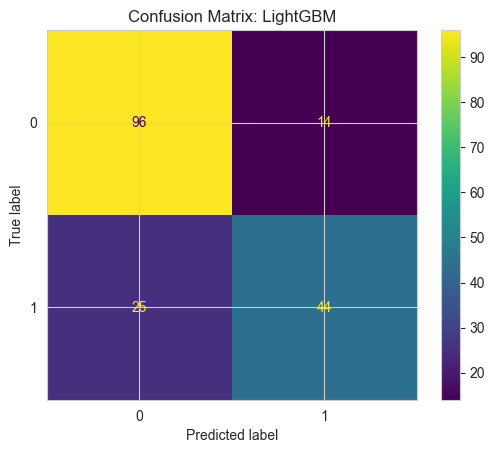


--- XGBoost ---
Accuracy: 0.7988826815642458
Precision: 0.7796610169491526
Recall: 0.6666666666666666
F1: 0.71875
ROC AUC: 0.8321475625823451

Classification report:
               precision    recall  f1-score   support

           0       0.81      0.88      0.84       110
           1       0.78      0.67      0.72        69

    accuracy                           0.80       179
   macro avg       0.79      0.77      0.78       179
weighted avg       0.80      0.80      0.80       179



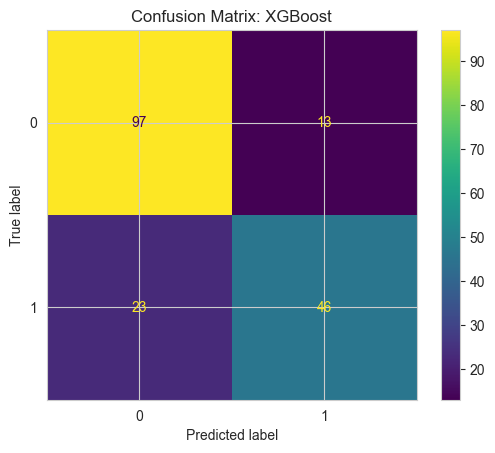

In [39]:
# Evaluate LightGBM
lgbm_metrics = evaluate_model(best_lgbm, X_test, y_test, "LightGBM")

# Evaluate XGBoost
xgb_metrics  = evaluate_model(best_xgb, X_test, y_test, "XGBoost")


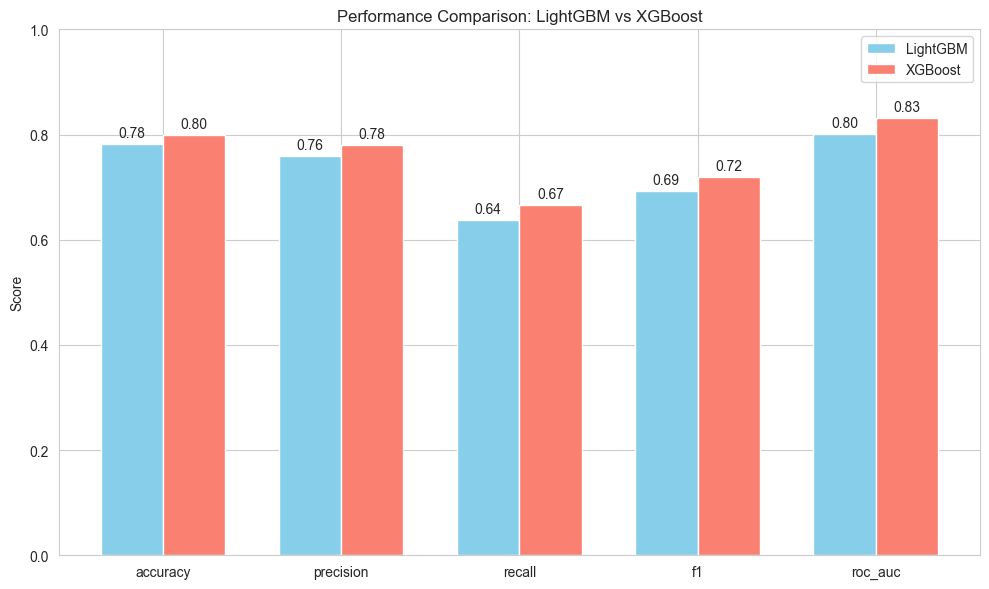

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
metrics_df = pd.DataFrame([lgbm_metrics, xgb_metrics], index=["LightGBM", "XGBoost"])
metrics = metrics_df.columns.tolist()
models = metrics_df.index.tolist()

# Plot
fig, ax = plt.subplots(figsize=(10,6))
x = np.arange(len(metrics))  # metric positions
width = 0.35  # bar width

# Bars for each model
bars1 = ax.bar(x - width/2, metrics_df.loc["LightGBM"], width, label='LightGBM', color='skyblue')
bars2 = ax.bar(x + width/2, metrics_df.loc["XGBoost"], width, label='XGBoost', color='salmon')

# Add metric labels above bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0,3),
                textcoords="offset points",
                ha='center', va='bottom')

# Customize plot
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1)
ax.set_ylabel("Score")
ax.set_title("Performance Comparison: LightGBM vs XGBoost")
ax.legend()
plt.tight_layout()
plt.show()
